# Death Prediction Project: Exploring Novel Models with Benchmarks

## Description
This project explores predictive modeling techniques for death prediction using a dataset with demographic and temporal features. The goal is to predict the **year of death** for individuals based on the given features.

### Models Implemented:
- **XGBoost**: Used as a benchmark model, achieving ~78% accuracy for ±1 year error tolerance.
- **DF2M (Deep Functional Factor Models)**: Currently under implementation, leveraging sparse factorization, Gaussian Processes, and deep kernels for explainable and robust predictions.
- **MOIRAI**: Planned implementation as another novel model for comparison, leveraging advanced transformer architectures for universal time-series forecasting.

### Objectives:
1. **Benchmarking**: Evaluate baseline performance using XGBoost.
2. **Novel Approaches**: Implement and test research-based models such as DF2M and MOIRAI.
3. **Learning**: Showcase the ability to read, implement, and adapt cutting-edge research into real-world predictive tasks.

### Progress:
- **Data Preprocessing**: Completed with handling of missing values, feature encoding, and scaling.
- **XGBoost**: Successfully implemented as the benchmark model.
- **DF2M**: Currently under active development.
- **MOIRAI**: Implementation planned as the next step.

### Next Steps:
1. Finalize the implementation of DF2M and evaluate its performance against XGBoost.
2. Integrate MOIRAI into the project to compare its performance on the same dataset.
3. Analyze results and document key insights from the model evaluations.


# Import Libraries, Dependencies and Dataset


In [1]:
!pip install pytorch-tabnet > /dev/null 2>&1
!pip install pyro-ppl > /dev/null 2>&1
!pip install gpytorch > /dev/null 2>&1
!pip install kagglehub > /dev/null 2>&1


In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# bayesian modeling with pyro
import pyro
from pyro.infer import SVI, Trace_ELBO, config_enumerate 
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.distributions import Normal, Bernoulli, MultivariateNormal, constraints
import pyro.poutine as poutine
from pyro.optim import Adam


# guassian processoes with gpytorch
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean


# proprocessings
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import time

In [3]:
# Dataset download
path = kagglehub.dataset_download("imoore/age-dataset")

print("Path to dataset files:", path)
dataset_path = "/home/codespace/.cache/kagglehub/datasets/imoore/age-dataset/versions/1"
print("Files in dataset directory:", os.listdir(dataset_path))

file_path = os.path.join(dataset_path, "AgeDataset-V1.csv")  #
df = pd.read_csv(file_path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/imoore/age-dataset/versions/1
Files in dataset directory: ['AgeDataset-V1.csv']


In [4]:
print(df.head())
print(df.info())
print(df.describe())

     Id                     Name  \
0   Q23        George Washington   
1   Q42            Douglas Adams   
2   Q91          Abraham Lincoln   
3  Q254  Wolfgang Amadeus Mozart   
4  Q255     Ludwig van Beethoven   

                                 Short description Gender  \
0   1st president of the United States (1732–1799)   Male   
1                      English writer and humorist   Male   
2  16th president of the United States (1809-1865)   Male   
3        Austrian composer of the Classical period   Male   
4           German classical and romantic composer   Male   

                                             Country  Occupation  Birth year  \
0  United States of America; Kingdom of Great Bri...  Politician        1732   
1                                     United Kingdom      Artist        1952   
2                           United States of America  Politician        1809   
3    Archduchy of Austria; Archbishopric of Salzburg      Artist        1756   
4               

# General Visuals

/tmp/ipykernel_2667/775677463.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel', ax=axes[1])
/tmp/ipykernel_2667/775677463.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


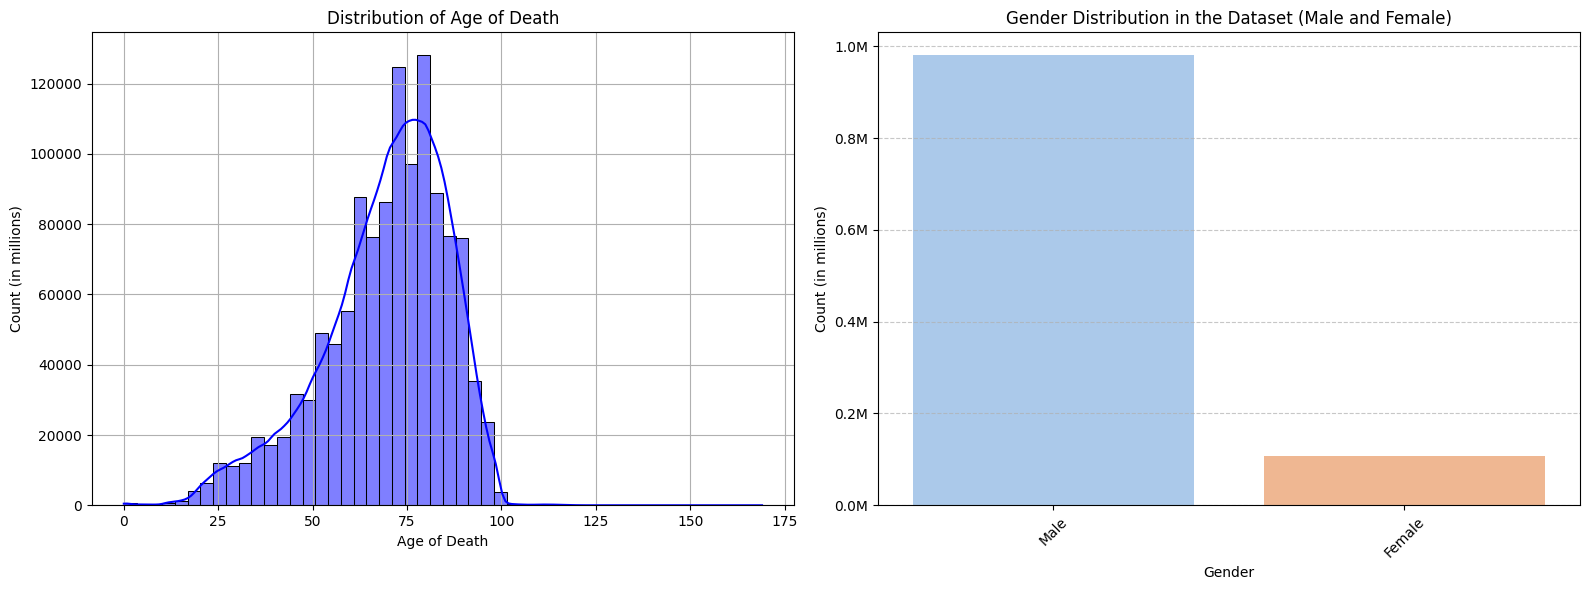

/tmp/ipykernel_2667/775677463.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_occupations.index, x=top_occupations.values, palette='viridis', ax=axes[0])
/tmp/ipykernel_2667/775677463.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_deaths.values, y=top_deaths.index, palette='plasma', ax=axes[1])
/tmp/ipykernel_2667/775677463.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='plasma', ax=axes[2])


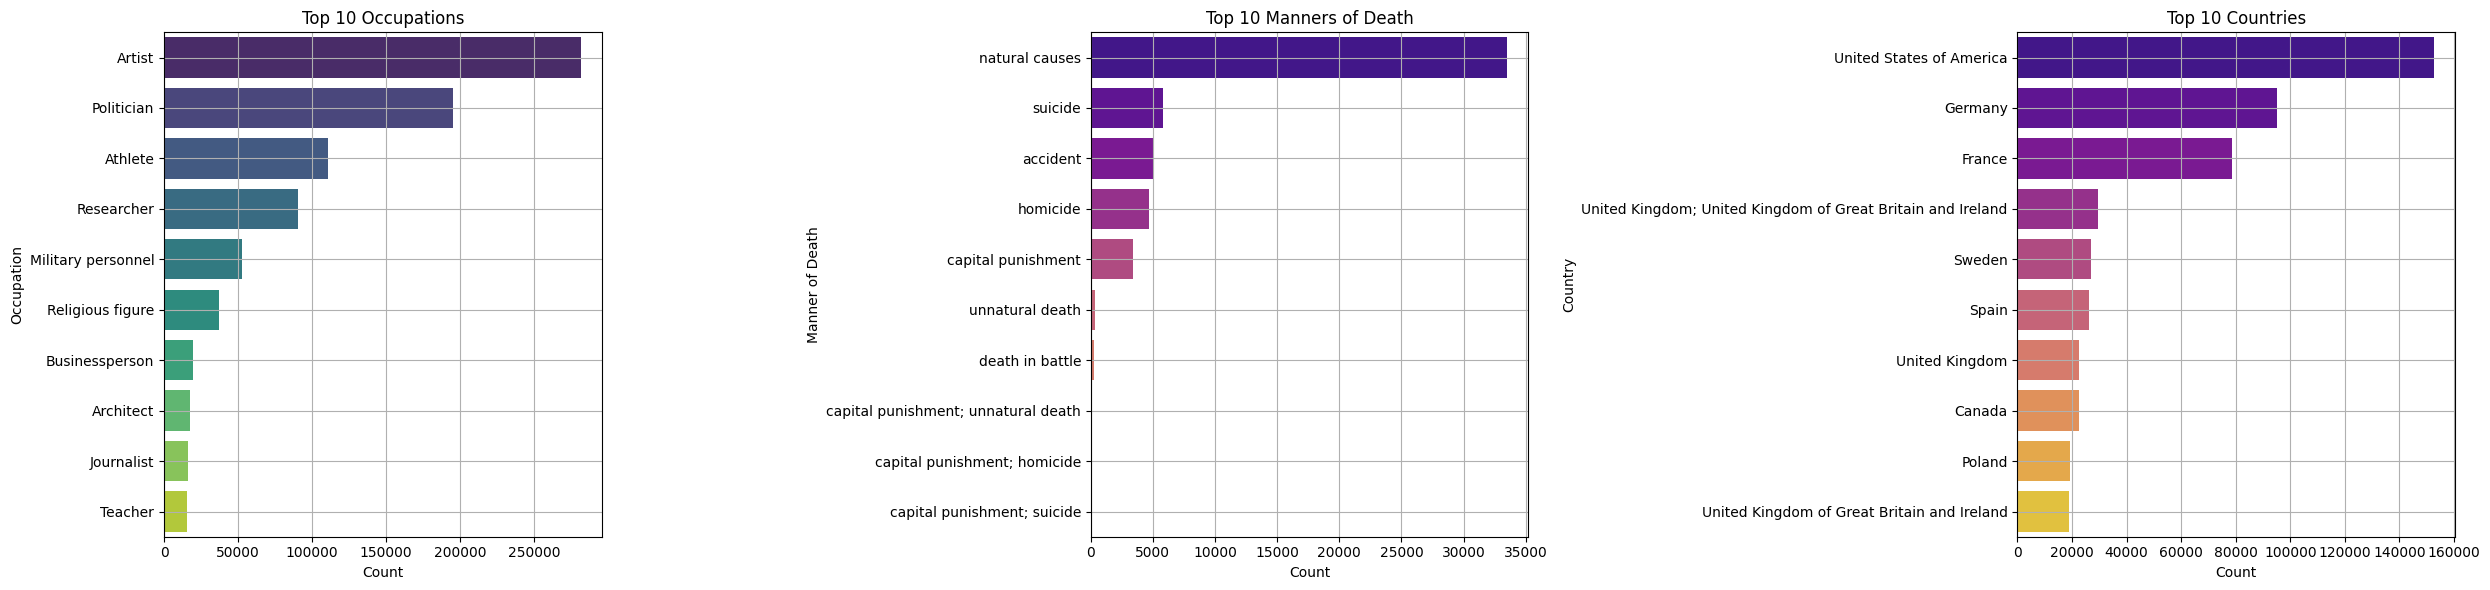

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# General distribution of age
sns.histplot(df['Age of death'], bins=50, kde=True, color='blue', ax=axes[0])
axes[0].set_title('Distribution of Age of Death')
axes[0].set_xlabel('Age of Death')
axes[0].set_ylabel('Count (in millions)')
axes[0].grid(True)

# Distribution of Gender
gender_counts = df['Gender'].value_counts().loc[['Male', 'Female']]  # Filter for Male and Female
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel', ax=axes[1])
axes[1].set_title('Gender Distribution in the Dataset (Male and Female)')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count (in millions)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(25, 6))

# Top 10 Occupations
top_occupations = df['Occupation'].value_counts().head(10)
sns.barplot(y=top_occupations.index, x=top_occupations.values, palette='viridis', ax=axes[0])
axes[0].set_title('Top 10 Occupations')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Occupation')
axes[0].grid(True)

# Top 10 Manners of Death
top_deaths = df['Manner of death'].value_counts().head(10)
sns.barplot(x=top_deaths.values, y=top_deaths.index, palette='plasma', ax=axes[1])
axes[1].set_title('Top 10 Manners of Death')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Manner of Death')
axes[1].grid(True)

# Top 10 Countries
top_countries = df['Country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='plasma', ax=axes[2])
axes[2].set_title('Top 10 Countries')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Country')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Preprocessing

In [6]:
# Initial Data Info
print(f"Initial dataset shape: {df.shape}")

# Step 1: Handle missing data directly on the original dataframe
df['Gender'] = df['Gender'].fillna('Unknown')
df['Country'] = df['Country'].fillna('Unknown')
df['Occupation'] = df['Occupation'].fillna('Unknown')
df = df.dropna(subset=['Death year', 'Age of death'])  # Drop rows with missing target values
print(f"After dropping rows with missing 'Death year' and 'Age of death': {df.shape}")

# Step 2: Drop 'Manner of death' column
if 'Manner of death' in df.columns:
    df = df.drop(['Manner of death'], axis=1)
    print("Dropped the 'Manner of death' column.")
print(f"Dataset shape after dropping 'Manner of death': {df.shape}")

# Step 3: Encode 'Country' and 'Occupation' using LabelEncoder (less memory-intensive)
print("Optimizing categorical encoding (Country, Occupation)...")
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])
df['Occupation'] = label_encoder.fit_transform(df['Occupation'])
print(f"Dataset shape after label encoding: {df.shape}")

# Step 4: Define target feature
target = 'Age of death'
X = df.drop(columns=[target])
y = df[target]
print(f"Features (X) shape: {X.shape}, Target (y) shape: {y.shape}")

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# Step 6: Sample a smaller subset of the training data (e.g., 10%)
sample_fraction = 0.1
X_train_sample, y_train_sample = resample(
    X_train, y_train, n_samples=int(sample_fraction * len(X_train)), random_state=42
)
print(
    f"Sampled training set shape: X_train_sample={X_train_sample.shape}, y_train_sample={y_train_sample.shape}"
)

# Step 7: Process TF-IDF for 'Short description' on the sampled data
print(f"Processing TF-IDF for 'Short description' on sampled data...")
tfidf = TfidfVectorizer(max_features=100)
X_train_sample['Short description'] = X_train_sample['Short description'].fillna('')
tfidf_matrix = tfidf.fit_transform(X_train_sample['Short description'])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out()
)
print(f"TF-IDF matrix shape: {tfidf_df.shape}")

# Concatenate TF-IDF to the sampled data
X_train_sample = pd.concat(
    [X_train_sample.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1
)
X_train_sample = X_train_sample.drop(columns=['Short description'], errors='ignore')
print(f"Sampled dataset shape after TF-IDF transformation: {X_train_sample.shape}")

# Step 8: One-hot encode 'Gender' on the sampled data
print("One-hot encoding 'Gender' on sampled data...")
X_train_sample = pd.get_dummies(X_train_sample, columns=['Gender'], drop_first=True)
print(f"Sampled dataset shape after encoding 'Gender': {X_train_sample.shape}")

# Step 9: Scale numerical columns on the sampled data
print("Scaling numerical columns on sampled data...")
scaler = StandardScaler()
numerical_cols = ['Birth year', 'Death year']
X_train_sample[numerical_cols] = scaler.fit_transform(X_train_sample[numerical_cols])
print(f"Sampled dataset shape after scaling numerical columns: {X_train_sample.shape}")

# Step 10: Drop irrelevant columns on the sampled data
X_train_sample = X_train_sample.drop(['Name', 'Id'], axis=1, errors='ignore')
print("Dropped irrelevant columns on sampled data: 'Name', 'Id'.")
print(f"Sampled dataset shape after dropping irrelevant columns: {X_train_sample.shape}")

Initial dataset shape: (1223009, 10)
After dropping rows with missing 'Death year' and 'Age of death': (1223008, 10)
Dropped the 'Manner of death' column.
Dataset shape after dropping 'Manner of death': (1223008, 9)
Optimizing categorical encoding (Country, Occupation)...
Dataset shape after label encoding: (1223008, 9)
Features (X) shape: (1223008, 8), Target (y) shape: (1223008,)
Training set shape: X_train=(978406, 8), y_train=(978406,)
Test set shape: X_test=(244602, 8), y_test=(244602,)
Sampled training set shape: X_train_sample=(97840, 8), y_train_sample=(97840,)
Processing TF-IDF for 'Short description' on sampled data...
TF-IDF matrix shape: (97840, 100)
Sampled dataset shape after TF-IDF transformation: (97840, 107)
One-hot encoding 'Gender' on sampled data...
Sampled dataset shape after encoding 'Gender': (97840, 114)
Scaling numerical columns on sampled data...
Sampled dataset shape after scaling numerical columns: (97840, 114)
Dropped irrelevant columns on sampled data: 'Na

## **DF2M Model**

### 1. Define the DF2M Architecture
- **Build the Sparse Factorization**: Use the Indian Buffet Process (IBP) to create a sparse factor matrix for latent representation.
- **Implement Gaussian Process Dynamical Models**: Capture temporal dependencies using Gaussian Processes (GPs).
- **Create Deep Temporal Kernels**: Use LSTM, GRU, or Attention mechanisms to capture nonlinear and non-Markovian patterns.

### 2. Train the Model
- Use **variational inference** with the **ELBO loss** (Evidence Lower Bound) to optimize the model parameters.

### 3. Evaluate the Model
- Assess predictive performance using metrics such as:
  - **Mean Absolute Error (MAE)**
  - **Root Mean Squared Error (RMSE)**

In [24]:
# Build necessary functions

# IBF
def indian_buffet_process(alpha, n_customers):
    """
    Simulates the Indian Buffet Process (IBP) to generate a sparse binary matrix.
    :param alpha: Controls the expected number of new latent features.
    :param n_customers: Number of rows in the binary matrix (observations).
    :return: A sparse binary matrix Z.
    """
    Z = np.zeros((n_customers, 0))  # Initialize an empty binary matrix
    for i in range(n_customers):
        # Sample existing dishes
        for k in range(Z.shape[1]):
            prob = np.sum(Z[:i, k]) / (i + 1)
            Z[i, k] = np.random.rand() < prob
        # Sample new dishes
        new_dishes = np.random.poisson(alpha / (i + 1))
        Z = np.hstack((Z, np.zeros((n_customers, new_dishes))))
        Z[i, -new_dishes:] = 1
    return Z

# Gaussian Process Component
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Deep Kernel Construction
class DeepKernel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DeepKernel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out)


In [28]:
# DF2M Model
class DF2M(nn.Module):
    def __init__(self, input_dim, alpha, n_customers, hidden_dim, likelihood):
        super(DF2M, self).__init__()
        self.ibp_matrix = torch.tensor(indian_buffet_process(alpha, n_customers), dtype=torch.float32)
        self.deep_kernel = DeepKernel(input_dim, hidden_dim)
        self.likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-3))
        self.gp = GPModel(self.train_x, self.train_y, self.likelihood)

        # Placeholder for training data
        self.train_x = None
        self.train_y = None

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() == 2:
            x = x.unsqueeze(1)
        deep_features = self.deep_kernel(x)
        deep_features = deep_features.squeeze(-1)

        # Initialize GP with the batch data if it's not already initialized or if we have new training data
        if self.gp is None or self.train_x.shape[0] != deep_features.shape[0]:
            self.train_x = deep_features
            self.train_y = torch.zeros(deep_features.shape[0]).to(x.device)  # Use a placeholder tensor for y
            self.gp = GPModel(self.train_x, self.train_y, self.likelihood)
            self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.gp)

        # Set GP to eval mode if not training
        if not self.training:
            self.gp.eval()

        gp_output = self.gp(deep_features)
        return gp_output

    def update_gp(self, x, y):
        """Updates the GP model with new training data."""
        if self.gp is not None:
            # Update the training data in the GP model
            self.gp.set_train_data(inputs=x, targets=y, strict=False)
            self.train_x = self.gp.train_inputs[0]
            self.train_y = self.gp.train_targets
        else:
            # Initialize the GP model if it hasn't been initialized yet
            self.gp = GPModel(x, y, self.likelihood)
            self.train_x = self.gp.train_inputs[0]
            self.train_y = self.gp.train_targets
            self.mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.gp)

    def train_gp(self, optimizer, num_steps=1):
        """Trains the GP model."""
        self.train()  # Set the model to training mode
        self.likelihood.train()

        for i in range(num_steps):
            optimizer.zero_grad()
            output = self.gp(self.train_x)
            loss = -self.mll(output, self.train_y)
            loss.backward()
            optimizer.step()

In [26]:
# ---- parameters and training ----

alpha = 2.0
n_customers = len(X_train_sample)
input_dim = X_train_sample.shape[1]
hidden_dim = 16

# Initialize likelihood
likelihood = GaussianLikelihood()

# Define the DF2M model
df2m_model = DF2M(
    input_dim=input_dim,
    alpha=alpha,
    n_customers=n_customers,
    hidden_dim=hidden_dim,
    likelihood=likelihood
)

# Move model and likelihood to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
df2m_model.to(device)
likelihood.to(device)

print(f"Number of rows: {n_customers}")
print(f"Feature shape: {X_train_tensor.shape}, Target shape: {y_train_tensor.shape}")

Number of rows: 97840
Feature shape: torch.Size([97840, 112]), Target shape: torch.Size([97840])


In [29]:
# --- Train GP model (before SVI) ---
# Set model and likelihood to training mode
df2m_model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(df2m_model.parameters(), lr=0.01)

# Number of training iterations for the GP
num_train_iter = 50

# Use a DataLoader for batching
batch_size = 1024  # Adjust batch size as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for i in range(num_train_iter):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Update and train the GP
        df2m_model.update_gp(x_batch, y_batch)
        df2m_model.train_gp(optimizer, num_steps=1)  # Train for a few steps per batch

        print(f'Iter {i+1}/{num_train_iter}, Batch {batch_idx+1}/{len(train_loader)} - GP Updated and Trained')

# Set model and likelihood to eval mode for SVI
df2m_model.eval()
likelihood.eval()

/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 241.7109832763672 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 1/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 371.9576721191406 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 2/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 669.6484985351562 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 3/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 242.96954345703125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 4/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 450.4542236328125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 5/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 423.2528381347656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 6/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 329.9900817871094 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 7/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 177.49957275390625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 8/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 449.9912109375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 9/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 93.37846374511719 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 10/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 864.3511962890625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 11/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 65.23865509033203 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 12/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1811.509765625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 13/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 220.43861389160156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 14/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 193.10391235351562 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 15/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 312.5335998535156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 16/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 182.835205078125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 17/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 231.57730102539062 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 18/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 225.15640258789062 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 19/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 520.4156494140625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 20/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 75.42646026611328 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 21/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 308.0555114746094 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 22/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 289.05712890625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 23/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 384.5121765136719 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 24/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 170.3399200439453 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 25/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 314.3796081542969 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 26/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 172.78224182128906 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 27/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 445.9372253417969 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 28/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 414.8246765136719 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 29/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1769.3023681640625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 30/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 242.62940979003906 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 31/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 163.52235412597656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 32/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 83.37464141845703 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 33/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 204.36801147460938 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 34/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 730.5770874023438 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 35/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 143.21463012695312 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 36/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 122.2383041381836 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 37/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 76.17693328857422 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 38/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 154.17738342285156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 39/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 122.08478546142578 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 40/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 338.5063781738281 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 41/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 207.73638916015625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 42/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 688.018310546875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 43/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 160.96035766601562 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 44/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 562.4470825195312 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 45/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 261.19354248046875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 46/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 153.03729248046875 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 47/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 175.66387939453125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 48/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 240.78945922851562 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 49/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 256.05316162109375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 50/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 94.7676773071289 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 51/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 335.2347106933594 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 52/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 276.1989440917969 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 53/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1166.108642578125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 54/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 215.95054626464844 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 55/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 125.97675323486328 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 56/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 148.2842254638672 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 57/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 34.64622497558594 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 58/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 84.200927734375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 59/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 128.85882568359375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 60/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 76.98299407958984 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 61/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 62.95840835571289 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 62/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 308.8443603515625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 63/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 61.56307601928711 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 64/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 43.00811004638672 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 65/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 169.6737823486328 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 66/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 57.459510803222656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 67/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 243.97915649414062 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 68/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 330.30560302734375 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 69/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 57.058753967285156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 70/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 111.55989074707031 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 71/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 193.86878967285156 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 72/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 223.24981689453125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 73/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 110.71434783935547 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 74/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 351.2502136230469 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 75/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 208.3762664794922 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 76/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 17.573244094848633 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 77/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2338.823486328125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 78/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 55.258644104003906 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 79/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 48.410709381103516 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 80/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 567.1338500976562 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 81/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 62.01008224487305 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 82/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 92.84394836425781 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 83/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 41.0167121887207 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 84/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 152.44032287597656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 85/96 - GP Updated and Trained
Iter 1/50, Batch 86/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 41.87080001831055 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 87/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 486.953125 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 88/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 111.64382934570312 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 89/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 108.84105682373047 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 90/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 693.7857666015625 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 91/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 85.27140045166016 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 92/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 244.9590301513672 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 93/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 48.32291030883789 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


Iter 1/50, Batch 94/96 - GP Updated and Trained
Iter 1/50, Batch 95/96 - GP Updated and Trained


/usr/local/python/3.12.1/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 261.8768615722656 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.